In [45]:
# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

In [46]:
# Carregar a base de dados e criar o DataFrame
url = 'https://raw.githubusercontent.com/JoilsonMartins/telecom_x_parte2/refs/heads/main/dados_tratados.csv'
dados = pd.read_csv(url)
dados.head()

,id_Cliente,evasao,genero,idoso,companheiro,dependentes,meses_de_contrato,servico_telefonico,multiplas_linhas,tipo_internet,...,protecao_dispositivo,suporte_tecnico,streaming_tv,streaming_filmes,tipo_contrato,fatura_digital,forma_pagamento,contas_diarias,gasto_mensal,gasto_total
0,0002-ORFBO,Nao,Mulher,Nao,Sim,Sim,9,Sim,Nao,DSL,...,Nao,Sim,Sim,Nao,Anual,Sim,Cheque,2.19,65.6,593.30
1,0003-MKNFE,Nao,Homem,Nao,Nao,Nao,9,Sim,Sim,DSL,...,Nao,Nao,Nao,Sim,Mensal,Nao,Cheque,2.00,59.9,542.40
2,0004-TLHLJ,Sim,Homem,Nao,Nao,Nao,4,Sim,Nao,Fibra óptica,...,Sim,Nao,Nao,Nao,Mensal,Sim,Cheque eletrônico,2.46,73.9,280.85
3,0011-IGKFF,Sim,Homem,Sim,Sim,Nao,13,Sim,Nao,Fibra óptica,...,Sim,Nao,Sim,Sim,Mensal,Sim,Cheque eletrônico,3.27,98.0,1237.85
4,0013-EXCHZ,Sim,Mulher,Sim,Sim,Nao,3,Sim,Nao,Fibra óptica,...,Nao,Sim,Sim,Nao,Mensal,Sim,Cheque,2.80,83.9,267.40


##Remoção de Colunas Irrelevantes

In [47]:
# Remover o campo id_Cliente
dados.drop(columns=['id_Cliente'], inplace=True)

In [48]:
# Verificar os campos restantes
dados.columns

Index(['evasao', 'genero', 'idoso', 'companheiro', 'dependentes',
       'meses_de_contrato', 'servico_telefonico', 'multiplas_linhas',
       'tipo_internet', 'seguranca_online', 'backup_online',
       'protecao_dispositivo', 'suporte_tecnico', 'streaming_tv',
       'streaming_filmes', 'tipo_contrato', 'fatura_digital',
       'forma_pagamento', 'contas_diarias', 'gasto_mensal', 'gasto_total'],
      dtype='object')

## Verificação da Proporção de Evasão

In [49]:
# Contar a quantidade de "Sim" e "Não" no campo evasao
dados.evasao.value_counts()

,count
evasao,
Nao,5174
Sim,1869


In [50]:
# Visualizar graficamente a proporção de evasão
px.histogram(dados, x ='evasao', title = 'Contagem de Evasões', template = 'simple_white', text_auto=True, color = 'evasao', color_discrete_map={"Nao": "blue", "Sim": "red"})

## Enconding

In [51]:
# Verificar os campos categóricos e seus dados para aplicar enconding
for i in list(dados.columns):
  print(i)
  print(dados[i].unique())

evasao
['Nao' 'Sim']
genero
['Mulher' 'Homem']
idoso
['Nao' 'Sim']
companheiro
['Sim' 'Nao']
dependentes
['Sim' 'Nao']
meses_de_contrato
[ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42
  0]
servico_telefonico
['Sim' 'Nao']
multiplas_linhas
['Nao' 'Sim' 'Sem servico de telefone']
tipo_internet
['DSL' 'Fibra óptica' 'Nao']
seguranca_online
['Nao' 'Sim' 'Sem servico de internet']
backup_online
['Sim' 'Nao' 'Sem servico de internet']
protecao_dispositivo
['Nao' 'Sim' 'Sem servico de internet']
suporte_tecnico
['Sim' 'Nao' 'Sem servico de internet']
streaming_tv
['Sim' 'Nao' 'Sem servico de internet']
streaming_filmes
['Nao' 'Sim' 'Sem servico de internet']
tipo_contrato
['Anual' 'Mensal' 'Bienal']
fatura_digital
['Sim' 'Nao']
forma_pagamento
['Cheque' 'Cheque eletrônico' 'Cartão de crédito automático'
 'Transferência banc

In [52]:
# Criar dicionário
dic_sim_nao = {'Nao': 0, 'Sim': 1, 'Sem servico de telefone': 0, 'Sem servico de internet': 0}

# Selecionar campos com dados sim e não
campos_sim_nao = ['evasao', 'idoso', 'companheiro', 'dependentes', 'servico_telefonico', 'multiplas_linhas', 'seguranca_online',
                  'backup_online', 'protecao_dispositivo', 'suporte_tecnico', 'streaming_tv', 'streaming_filmes', 'fatura_digital']

for campo in campos_sim_nao:
  dados[campo] = dados[campo].map(dic_sim_nao)

In [53]:
# Aplicando encoding no campo genero
dic_genero = {'Homem': 0, 'Mulher': 1}
dados['genero'] = dados['genero'].map(dic_genero)

In [54]:
# Visualizar o resultado da aplicação de encoding
dados.head()

,evasao,genero,idoso,companheiro,dependentes,meses_de_contrato,servico_telefonico,multiplas_linhas,tipo_internet,seguranca_online,...,protecao_dispositivo,suporte_tecnico,streaming_tv,streaming_filmes,tipo_contrato,fatura_digital,forma_pagamento,contas_diarias,gasto_mensal,gasto_total
0,0,1,0,1,1,9,1,0,DSL,0,...,0,1,1,0,Anual,1,Cheque,2.19,65.6,593.30
1,0,0,0,0,0,9,1,1,DSL,0,...,0,0,0,1,Mensal,0,Cheque,2.00,59.9,542.40
2,1,0,0,0,0,4,1,0,Fibra óptica,0,...,1,0,0,0,Mensal,1,Cheque eletrônico,2.46,73.9,280.85
3,1,0,1,1,0,13,1,0,Fibra óptica,0,...,1,0,1,1,Mensal,1,Cheque eletrônico,3.27,98.0,1237.85
4,1,1,1,1,0,3,1,0,Fibra óptica,0,...,0,1,1,0,Mensal,1,Cheque,2.80,83.9,267.40


In [55]:
# Aplicar label encoding
ordem_contrato = ['Mensal', 'Anual', 'Bienal']
codificar_contrato = preprocessing.OrdinalEncoder(categories=[ordem_contrato])
dados['tipo_contrato'] = codificar_contrato.fit_transform(dados[['tipo_contrato']])

In [56]:
# Aplicar one hot enconding
dados = pd.get_dummies(data = dados, columns = ['tipo_internet', 'forma_pagamento'], dtype=int)

# Visualizar o resultado do label enconding e one hot enconding
dados.head()

,evasao,genero,idoso,companheiro,dependentes,meses_de_contrato,servico_telefonico,multiplas_linhas,seguranca_online,backup_online,...,contas_diarias,gasto_mensal,gasto_total,tipo_internet_DSL,tipo_internet_Fibra óptica,tipo_internet_Nao,forma_pagamento_Cartão de crédito automático,forma_pagamento_Cheque,forma_pagamento_Cheque eletrônico,forma_pagamento_Transferência bancária automático
0,0,1,0,1,1,9,1,0,0,1,...,2.19,65.6,593.30,1,0,0,0,1,0,0
1,0,0,0,0,0,9,1,1,0,0,...,2.00,59.9,542.40,1,0,0,0,1,0,0
2,1,0,0,0,0,4,1,0,0,0,...,2.46,73.9,280.85,0,1,0,0,0,1,0
3,1,0,1,1,0,13,1,0,0,1,...,3.27,98.0,1237.85,0,1,0,0,0,1,0
4,1,1,1,1,0,3,1,0,0,0,...,2.80,83.9,267.40,0,1,0,0,1,0,0


In [57]:
# Verificar a variance inflation factor (VIF)

X = dados.drop(columns = 'evasao')

# VIF DataFrame
vif_dados = pd.DataFrame()
vif_dados["feature"] = X.columns

# Calcular VIF para cada campo
vif_dados["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_dados)

                                              feature           VIF
0                                              genero  1.002375e+00
1                                               idoso  1.153621e+00
2                                         companheiro  1.464345e+00
3                                         dependentes  1.385398e+00
4                                   meses_de_contrato  7.526387e+00
5                                  servico_telefonico  3.486335e+01
6                                    multiplas_linhas  7.267736e+00
7                                    seguranca_online  6.336994e+00
8                                       backup_online  6.783101e+00
9                                protecao_dispositivo  6.922234e+00
10                                    suporte_tecnico  6.468780e+00
11                                       streaming_tv  2.406043e+01
12                                   streaming_filmes  2.411180e+01
13                                      tipo_con

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



In [58]:
# Remover campos causadores de multicolinearidade
dados_original = dados.copy()

dados.drop(columns = ['tipo_internet_Nao', 'contas_diarias', 'gasto_mensal', 'gasto_total', 'forma_pagamento_Cheque eletrônico'], inplace = True)

In [59]:
# Verificar a variance inflation factor (VIF) novamente
X = dados.drop(columns = 'evasao')

# VIF DataFrame
vif_dados = pd.DataFrame()
vif_dados["feature"] = X.columns

# Calcular VIF para cada campo
vif_dados["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_dados)

                                              feature       VIF
0                                              genero  1.915927
1                                               idoso  1.366592
2                                         companheiro  2.821918
3                                         dependentes  1.959644
4                                   meses_de_contrato  7.337042
5                                  servico_telefonico  7.019704
6                                    multiplas_linhas  2.395904
7                                    seguranca_online  1.938846
8                                       backup_online  2.083480
9                                protecao_dispositivo  2.243013
10                                    suporte_tecnico  2.046097
11                                       streaming_tv  2.639341
12                                   streaming_filmes  2.667365
13                                      tipo_contrato  4.132960
14                                     f

## Balanceamento

In [60]:
# Definir a semente e criar objeto SMOTE
SEED = 20

smote = SMOTE(random_state=SEED)


# Balancear os dados
x = dados.drop('evasao', axis=1)
y = dados['evasao']

x_resampled, y_resampled = smote.fit_resample(x,y)

dados_balanceados = pd.concat([y_resampled, x_resampled], axis=1)
dados_balanceados

,evasao,genero,idoso,companheiro,dependentes,meses_de_contrato,servico_telefonico,multiplas_linhas,seguranca_online,backup_online,...,suporte_tecnico,streaming_tv,streaming_filmes,tipo_contrato,fatura_digital,tipo_internet_DSL,tipo_internet_Fibra óptica,forma_pagamento_Cartão de crédito automático,forma_pagamento_Cheque,forma_pagamento_Transferência bancária automático
0,0,1,0,1,1,9,1,0,0,1,...,1,1,0,1.0,1,1,0,0,1,0
1,0,0,0,0,0,9,1,1,0,0,...,0,0,1,0.0,0,1,0,0,1,0
2,1,0,0,0,0,4,1,0,0,0,...,0,0,0,0.0,1,0,1,0,0,0
3,1,0,1,1,0,13,1,0,0,1,...,0,1,1,0.0,1,0,1,0,0,0
4,1,1,1,1,0,3,1,0,0,0,...,1,1,0,0.0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10343,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0.0,0,1,0,0,1,0
10344,1,0,0,0,0,2,1,1,0,1,...,0,0,0,0.0,1,0,1,0,0,0
10345,1,1,0,0,0,3,1,0,0,1,...,0,1,0,0.0,0,0,1,0,0,0
10346,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0.0,1,1,0,0,0,0


In [61]:
# Conferir dados balanceados
dados_balanceados.evasao.value_counts()

,count
evasao,
0,5174
1,5174


## Normalização

In [62]:
# Escalonar valores entre 0 e 1, com base nos valores máximo e mínimo dos campos
numericas = ['meses_de_contrato']

for coluna in numericas:

    valor_min = dados_balanceados[coluna].min()
    valor_max = dados_balanceados[coluna].max()

    dados_balanceados[coluna] = (dados_balanceados[coluna] - valor_min)/(valor_max-valor_min)

dados_balanceados.head()

,evasao,genero,idoso,companheiro,dependentes,meses_de_contrato,servico_telefonico,multiplas_linhas,seguranca_online,backup_online,...,suporte_tecnico,streaming_tv,streaming_filmes,tipo_contrato,fatura_digital,tipo_internet_DSL,tipo_internet_Fibra óptica,forma_pagamento_Cartão de crédito automático,forma_pagamento_Cheque,forma_pagamento_Transferência bancária automático
0,0,1,0,1,1,0.125000,1,0,0,1,...,1,1,0,1.0,1,1,0,0,1,0
1,0,0,0,0,0,0.125000,1,1,0,0,...,0,0,1,0.0,0,1,0,0,1,0
2,1,0,0,0,0,0.055556,1,0,0,0,...,0,0,0,0.0,1,0,1,0,0,0
3,1,0,1,1,0,0.180556,1,0,0,1,...,0,1,1,0.0,1,0,1,0,0,0
4,1,1,1,1,0,0.041667,1,0,0,0,...,1,1,0,0.0,1,0,1,0,1,0


## Correlações

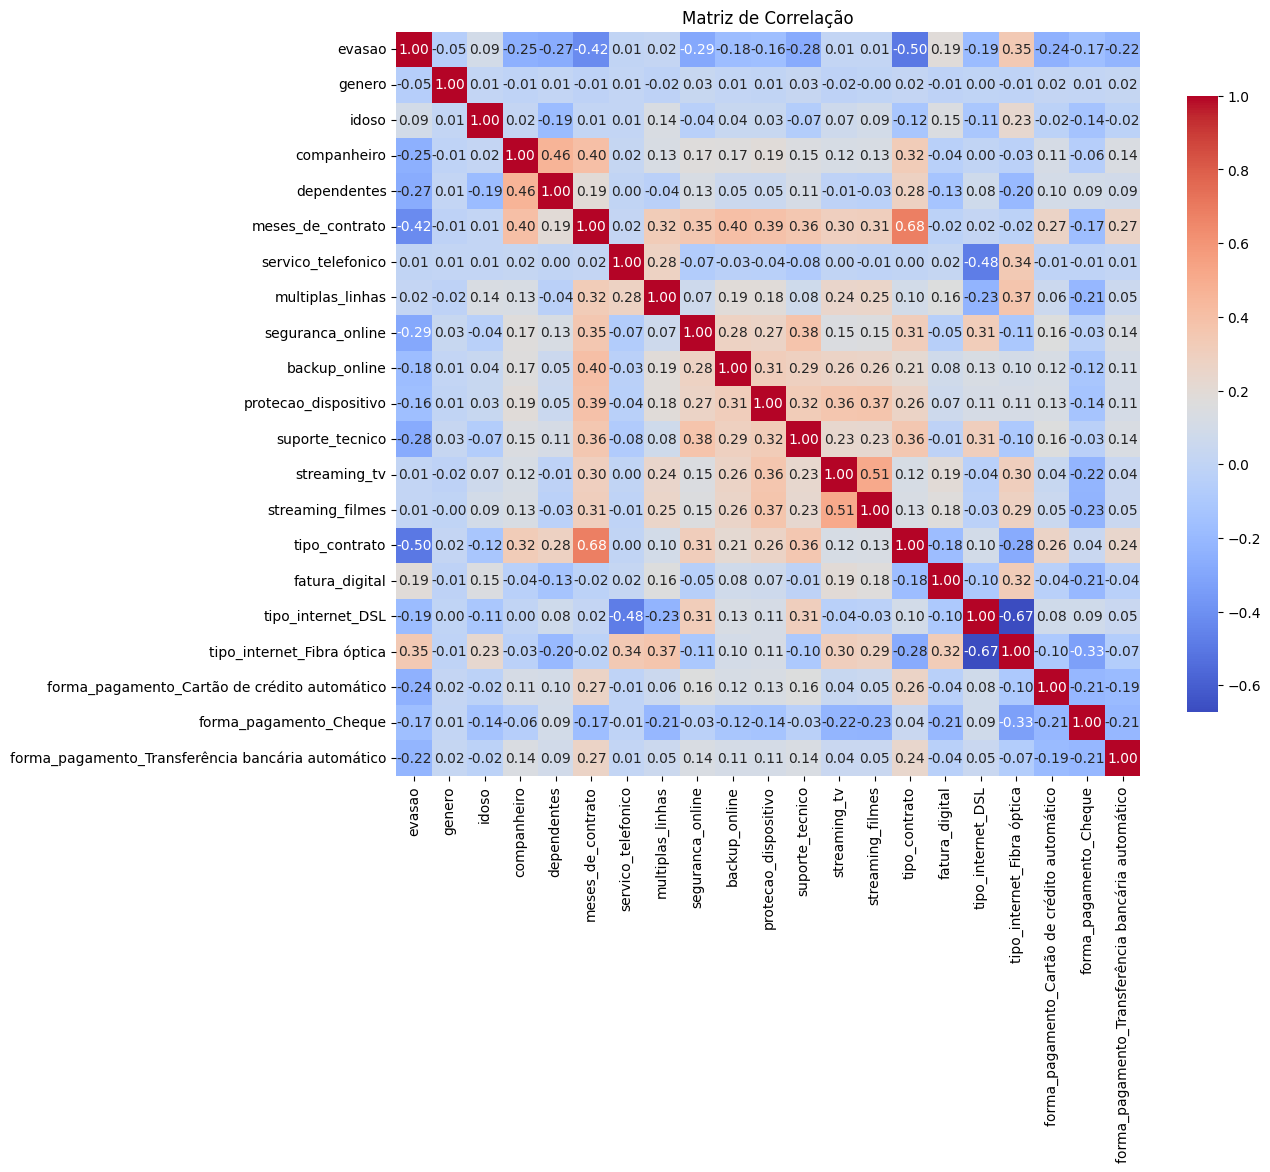

In [63]:
# Calcular a matriz de correlação
correlation_matrix = dados_balanceados.corr()

# Criar um mapa de calor da matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação')

plt.show()

## Modelagem Preditiva

In [64]:
#Dividir base em treino e teste
x = dados_balanceados.drop(columns = 'evasao')
y = dados_balanceados['evasao']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=SEED, stratify = y)

print("O treino será com %d elementos e o teste com %d elementos" % (len(x_train), len(x_test)))

O treino será com 7243 elementos e o teste com 3105 elementos


In [65]:
# Função para executar o modelo
def executa_modelo(modelo, x_train, x_test, y_train):

    modelo.fit(x_train,y_train)
    y_pred = modelo.predict(x_test)

    return y_pred

In [83]:
from sklearn import metrics

def metricas_modelo(y_test, y_pred):
    acuracia = metrics.accuracy_score(y_test, y_pred)
    precisao = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)

    metricas = [acuracia, precisao, recall, f1]
    cm = confusion_matrix(y_test, y_pred)

    return metricas, cm

In [84]:
# Função para plotar a matriz de confusão
def plotar_matriz_confusao(nome_classificador, cm):

    sns.set(rc = {'figure.figsize':(8,5)})
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")
    ax.set_title(' Matriz de confusão ' + nome_classificador, size = 15);
    ax.set_xlabel('\nPredicted Values', size = 15)
    ax.set_ylabel('Actual Values ', size = 15);

    ## Etiqueta das Labels
    ax.xaxis.set_ticklabels(['False','True'], size = 12)
    ax.yaxis.set_ticklabels(['False','True'], size = 12)

    ## Plotar a visualização da matriz de confusão
    plt.show()

In [85]:
# Função da curva ROC e AUC
def curva_roc(modelo, nome_classificador, y_test):

    y_pred_proba = modelo.predict_proba(x_test)[::,1]
    fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    plt.rcParams['figure.figsize'] = (12., 8.)
    plt.plot(fpr, tpr, label = nome_classificador + ' auc= '+str(auc))
    plt.plot([0 ,1], [0,1], color = 'red', lw = 2, linestyle = '--')
    plt.plot([0, 0], [1, 0], ls="--", c = 'green', lw = 2), plt.plot([1, 1], ls="--", c = 'green')
    plt.title('Curva ROC e AUC', size = 20)
    plt.xlabel("Taxa de falsos positivos", size = 15)
    plt.ylabel("Taxa de verdadeiros positivos", size = 15)
    plt.legend(loc = 4)

In [86]:
# Criar os modelos
dummy = DummyClassifier(random_state = SEED, strategy="uniform")
lr = LogisticRegression(max_iter = 1000, random_state = SEED)
rf = RandomForestClassifier(random_state = SEED)
svc = SVC(random_state = SEED, probability = True)
knc = KNeighborsClassifier()

classifiers = [dummy, lr, rf, svc, knc]

In [87]:
# Executar os modelos
resultados = {}

for classifier in classifiers:
    y_pred = executa_modelo(classifier, x_train, x_test, y_train)
    resultados[classifier] = y_pred

resultados

{DummyClassifier(random_state=20, strategy='uniform'): array([1, 0, 1, ..., 1, 0, 0]),
 LogisticRegression(max_iter=1000, random_state=20): array([0, 1, 1, ..., 1, 1, 1]),
 RandomForestClassifier(random_state=20): array([0, 1, 1, ..., 1, 1, 1]),
 SVC(probability=True, random_state=20): array([0, 1, 1, ..., 1, 1, 1]),
 KNeighborsClassifier(): array([0, 1, 1, ..., 1, 1, 1])}

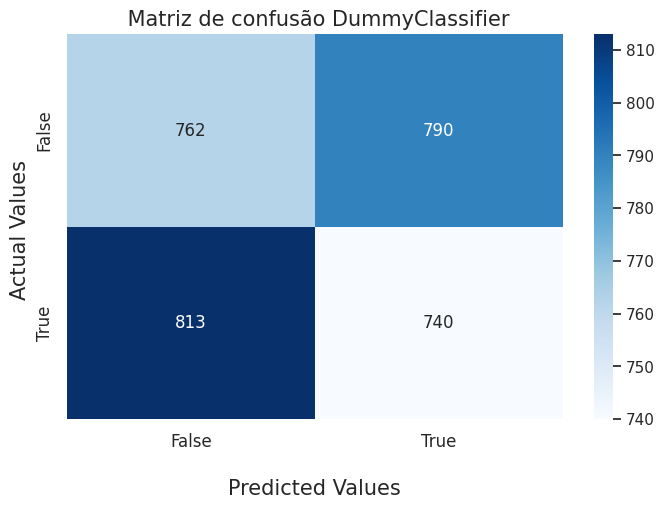

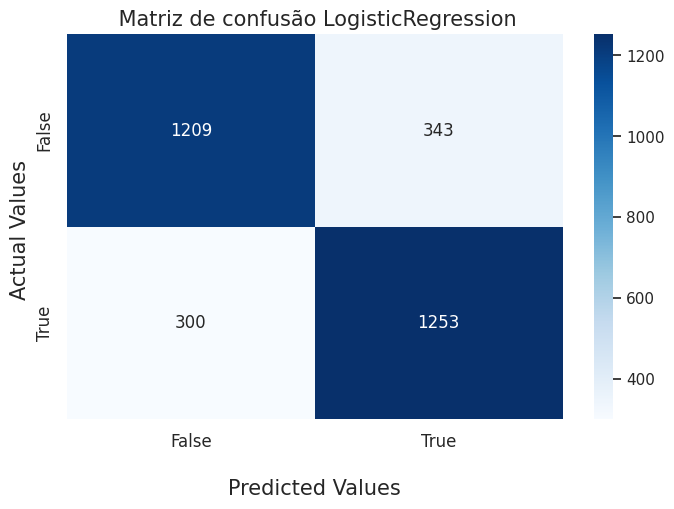

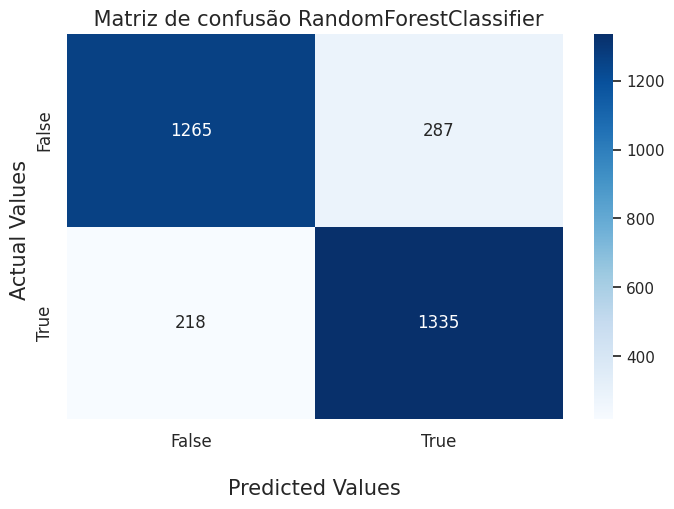

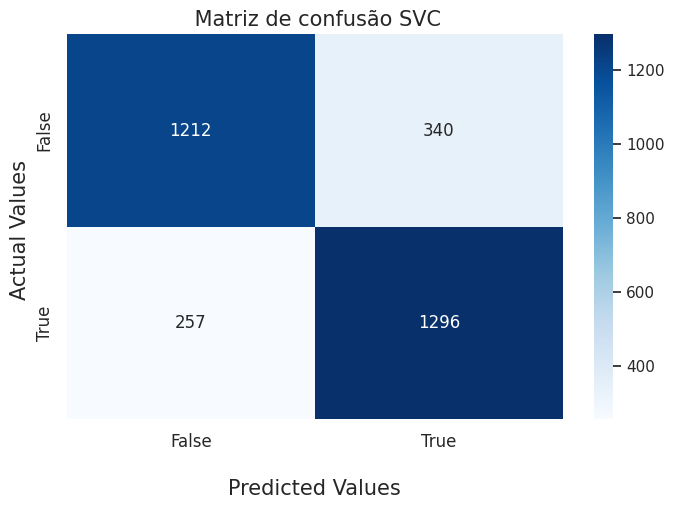

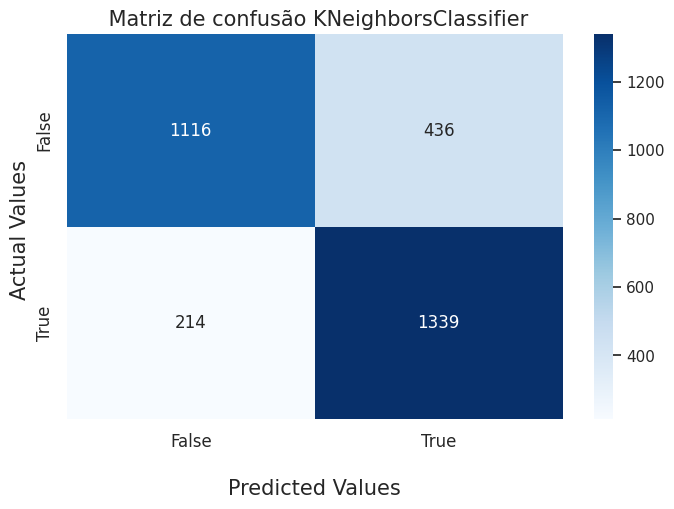

In [90]:
# Plotar a matriz de confusão e criar DataFrame com as métricas de validação dos modelos
index = ['Acurácia', 'Precisão', 'Recall', 'F1']
df_metricas = pd.DataFrame(index = index)

for modelo, y_pred in resultados.items():
    name = modelo.__class__.__name__
    metricas, cm = metricas_modelo(y_test, y_pred)
    df_metricas[name] = metricas
    plotar_matriz_confusao(name, cm)

In [91]:
df_metricas.T.sort_values('Recall', ascending = False)

,Acurácia,Precisão,Recall,F1
KNeighborsClassifier,0.790660,0.754366,0.862202,0.804688
RandomForestClassifier,0.837359,0.823058,0.859627,0.840945
SVC,0.807729,0.792176,0.834514,0.812794
LogisticRegression,0.792915,0.785088,0.806825,0.795808
DummyClassifier,0.483736,0.483660,0.476497,0.480052


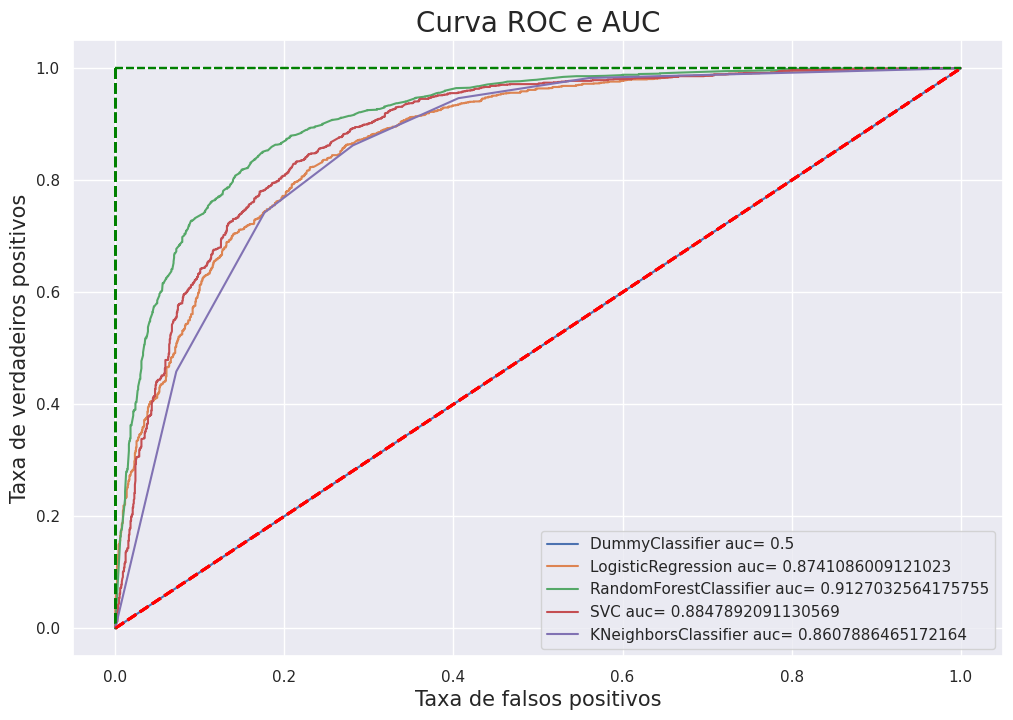

In [92]:
# Plotar a curva ROC e a AUC
for classifier in classifiers:
    name = classifier.__class__.__name__
    curva_roc(classifier, name, y_test)

In [93]:
n_estimators = np.arange(20, 200, step=20)
criterion = ["gini", "entropy"]
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(2, 10, step=1))
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [94]:
param_grid = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

In [95]:
new_rf = RandomForestClassifier(random_state=SEED)

In [96]:
random_cv = RandomizedSearchCV(new_rf, param_grid, n_iter=200, cv=3, scoring="recall", n_jobs=-1, verbose = 2,random_state = SEED)

In [97]:
%%time
rcv = random_cv.fit(x, y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


222 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
122 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/uti

CPU times: user 2.39 s, sys: 335 ms, total: 2.72 s
Wall time: 2min 25s


In [98]:
pd.DataFrame(rcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.519510,0.313528,0.135383,0.042237,160,4,1,sqrt,7,gini,True,"{'n_estimators': 160, 'min_samples_split': 4, ...",0.710145,0.911833,0.898551,0.840176,0.092106,109
1,0.957467,0.011336,0.075123,0.000739,160,2,2,log2,6,gini,True,"{'n_estimators': 160, 'min_samples_split': 2, ...",0.725217,0.910093,0.890435,0.841915,0.082907,95
2,0.123480,0.008886,0.020602,0.006976,20,6,2,log2,5,gini,True,"{'n_estimators': 20, 'min_samples_split': 6, '...",0.729275,0.911253,0.883478,0.841336,0.080046,99
3,0.002938,0.000068,0.000000,0.000000,160,2,4,auto,3,gini,True,"{'n_estimators': 160, 'min_samples_split': 2, ...",NaN,NaN,NaN,NaN,NaN,127
4,0.002887,0.000044,0.000000,0.000000,180,8,4,auto,2,gini,True,"{'n_estimators': 180, 'min_samples_split': 8, ...",NaN,NaN,NaN,NaN,NaN,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.005921,0.003833,0.000000,0.000000,80,8,2,auto,9,entropy,False,"{'n_estimators': 80, 'min_samples_split': 8, '...",NaN,NaN,NaN,NaN,NaN,127
196,0.002966,0.000038,0.000000,0.000000,60,4,1,auto,5,entropy,False,"{'n_estimators': 60, 'min_samples_split': 4, '...",NaN,NaN,NaN,NaN,NaN,127
197,0.002988,0.000102,0.000000,0.000000,100,8,2,auto,8,entropy,False,"{'n_estimators': 100, 'min_samples_split': 8, ...",NaN,NaN,NaN,NaN,NaN,127
198,0.718183,0.079613,0.052844,0.015780,80,2,2,log2,5,gini,False,"{'n_estimators': 80, 'min_samples_split': 2, '...",0.742609,0.910093,0.892754,0.848485,0.075200,58


In [99]:
rcv.best_params_

{'n_estimators': np.int64(100),
 'min_samples_split': np.int64(2),
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': np.int64(2),
 'criterion': 'gini',
 'bootstrap': True}

In [100]:
rfn = RandomForestClassifier(**rcv.best_params_, random_state = SEED)

model = rfn.fit(x_train, y_train)
y_pred = rfn.predict(x_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.7761674718196457
Precisão: 0.7243723849372385
Recall: 0.8918222794591114
F1: 0.7994227994227994


In [101]:
# Criar modelo com a base original
dados_original.head()

,evasao,genero,idoso,companheiro,dependentes,meses_de_contrato,servico_telefonico,multiplas_linhas,seguranca_online,backup_online,...,contas_diarias,gasto_mensal,gasto_total,tipo_internet_DSL,tipo_internet_Fibra óptica,tipo_internet_Nao,forma_pagamento_Cartão de crédito automático,forma_pagamento_Cheque,forma_pagamento_Cheque eletrônico,forma_pagamento_Transferência bancária automático
0,0,1,0,1,1,9,1,0,0,1,...,2.19,65.6,593.30,1,0,0,0,1,0,0
1,0,0,0,0,0,9,1,1,0,0,...,2.00,59.9,542.40,1,0,0,0,1,0,0
2,1,0,0,0,0,4,1,0,0,0,...,2.46,73.9,280.85,0,1,0,0,0,1,0
3,1,0,1,1,0,13,1,0,0,1,...,3.27,98.0,1237.85,0,1,0,0,0,1,0
4,1,1,1,1,0,3,1,0,0,0,...,2.80,83.9,267.40,0,1,0,0,1,0,0


In [103]:
x = dados_original.drop('evasao', axis=1)
y = dados_original['evasao']

x_resampled, y_resampled = smote.fit_resample(x,y)

dados_balanceados = pd.concat([y_resampled, x_resampled], axis=1)

dados_balanceados['evasao'].value_counts()

,count
evasao,
0,5174
1,5174


In [105]:
numericas = ['meses_de_contrato', 'contas_diarias', 'gasto_mensal', 'gasto_total']

for coluna in numericas:

    minimo = dados_balanceados[coluna].min()
    maximo = dados_balanceados[coluna].max()

    dados_balanceados[coluna] = (dados_balanceados[coluna] - minimo)/(maximo-minimo)

dados_balanceados.head()

,evasao,genero,idoso,companheiro,dependentes,meses_de_contrato,servico_telefonico,multiplas_linhas,seguranca_online,backup_online,...,contas_diarias,gasto_mensal,gasto_total,tipo_internet_DSL,tipo_internet_Fibra óptica,tipo_internet_Nao,forma_pagamento_Cartão de crédito automático,forma_pagamento_Cheque,forma_pagamento_Cheque eletrônico,forma_pagamento_Transferência bancária automático
0,0,1,0,1,1,0.125000,1,0,0,1,...,0.471642,0.471144,0.068315,1,0,0,0,1,0,0
1,0,0,0,0,0,0.125000,1,1,0,0,...,0.414925,0.414428,0.062454,1,0,0,0,1,0,0
2,1,0,0,0,0,0.055556,1,0,0,0,...,0.552239,0.553731,0.032338,0,1,0,0,0,1,0
3,1,0,1,1,0,0.180556,1,0,0,1,...,0.794030,0.793532,0.142531,0,1,0,0,0,1,0
4,1,1,1,1,0,0.041667,1,0,0,0,...,0.653731,0.653234,0.030789,0,1,0,0,1,0,0


In [107]:
x = dados_balanceados.drop(columns = 'evasao')
y = dados_balanceados['evasao']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=SEED, stratify = y)

In [108]:
dummy = DummyClassifier(random_state = SEED, strategy="uniform")
lr = LogisticRegression(max_iter = 1000, random_state = SEED)
rf = RandomForestClassifier(random_state = SEED)
svc = SVC(random_state = SEED, probability = True)
knc = KNeighborsClassifier()

classifiers = [dummy, lr, rf, svc, knc]

In [109]:
resultados = {}

for classifier in classifiers:
    y_pred = executa_modelo(classifier, x_train, x_test, y_train)
    resultados[classifier] = y_pred

resultados

{DummyClassifier(random_state=20, strategy='uniform'): array([1, 0, 1, ..., 1, 0, 0]),
 LogisticRegression(max_iter=1000, random_state=20): array([0, 1, 1, ..., 1, 1, 1]),
 RandomForestClassifier(random_state=20): array([0, 1, 1, ..., 1, 1, 1]),
 SVC(probability=True, random_state=20): array([0, 1, 1, ..., 0, 1, 1]),
 KNeighborsClassifier(): array([0, 0, 1, ..., 1, 1, 1])}

In [110]:
index = ['Acurácia', 'Precisão', 'Recall', 'F1']
df_metricas_1 = pd.DataFrame(index = index)

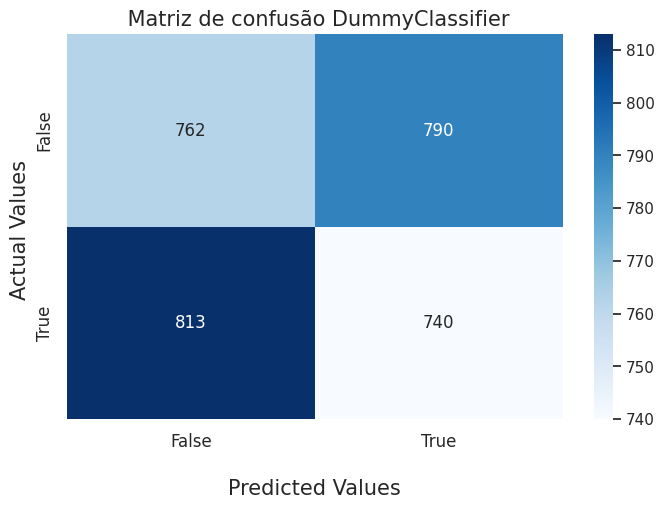

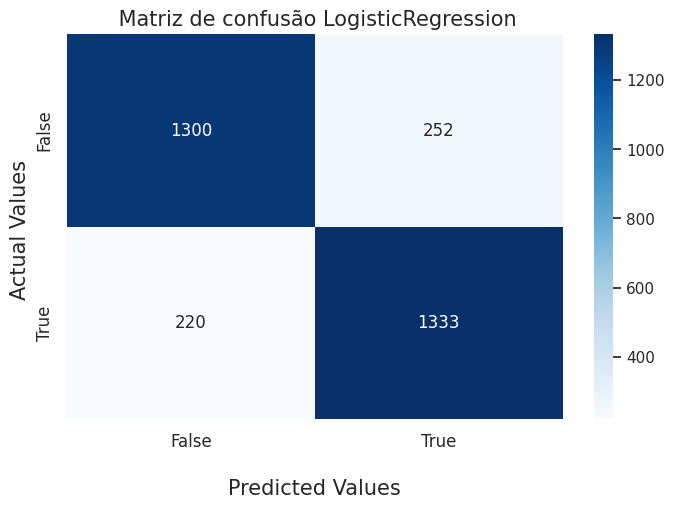

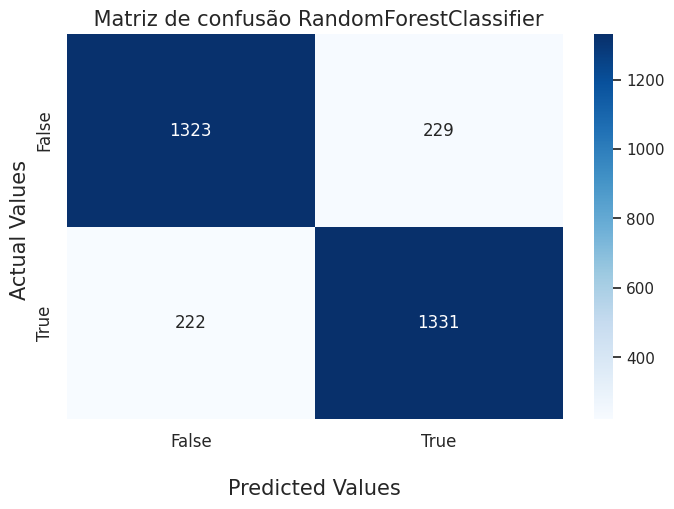

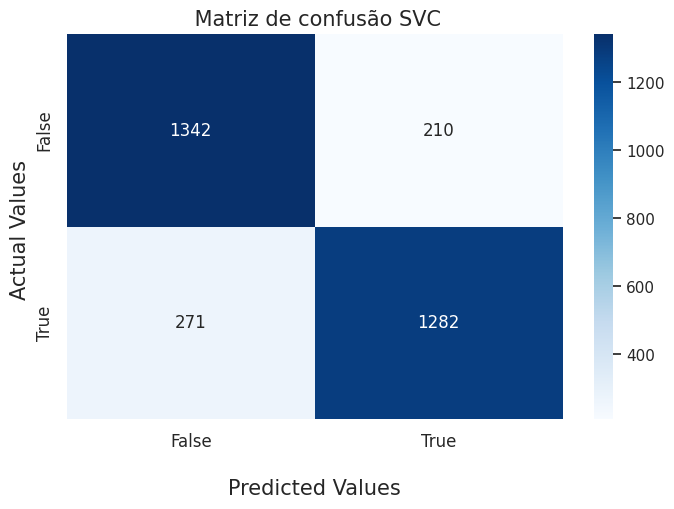

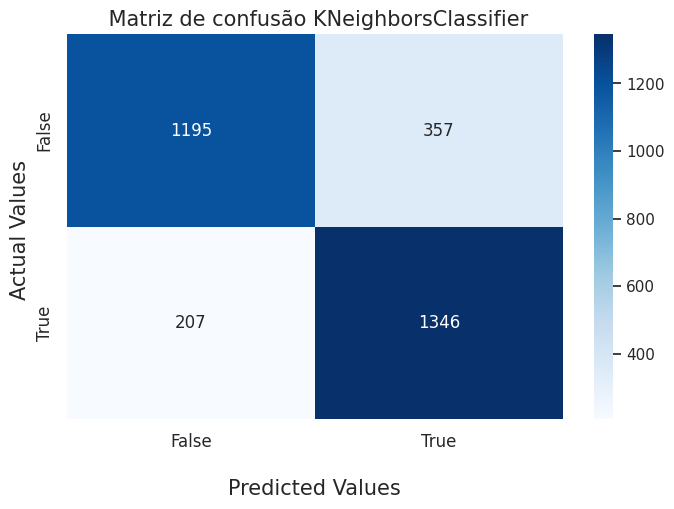

In [111]:
for modelo, y_pred in resultados.items():
    name = modelo.__class__.__name__
    metricas, cm = metricas_modelo(y_test, y_pred)
    df_metricas_1[name] = metricas
    plotar_matriz_confusao(name, cm)

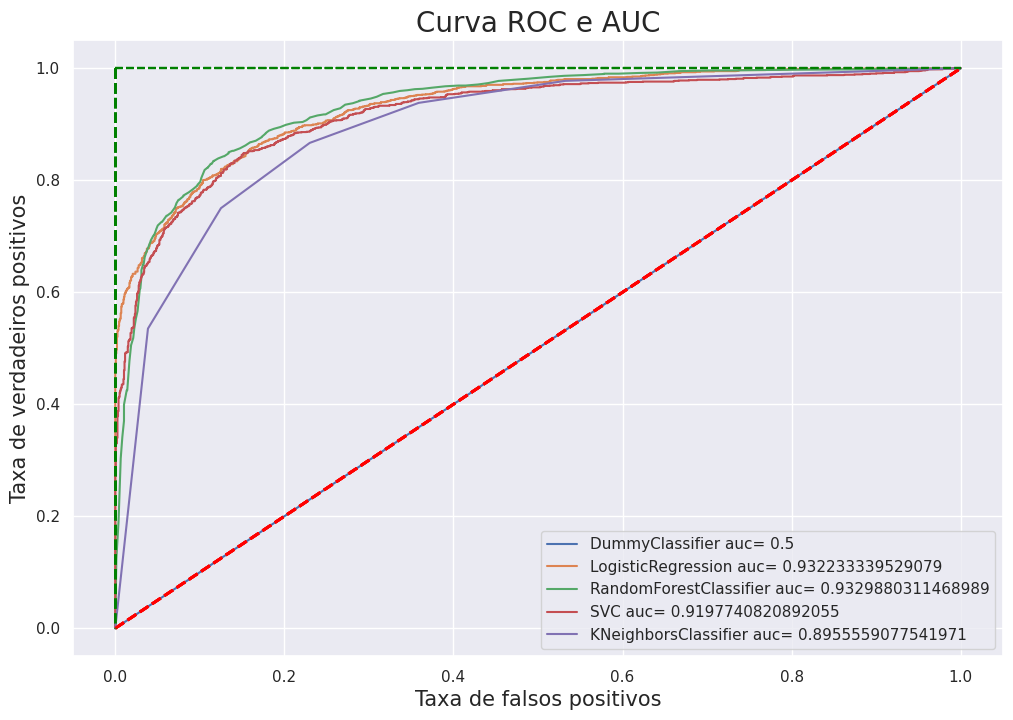

In [112]:
for classifier in classifiers:
    name = classifier.__class__.__name__
    curva_roc(classifier, name, y_test)

In [113]:
df_metricas_1.T.sort_values('Recall', ascending = False)

,Acurácia,Precisão,Recall,F1
KNeighborsClassifier,0.818357,0.790370,0.866710,0.826781
LogisticRegression,0.847987,0.841009,0.858339,0.849586
RandomForestClassifier,0.854750,0.853205,0.857051,0.855124
SVC,0.845089,0.859249,0.825499,0.842036
DummyClassifier,0.483736,0.483660,0.476497,0.480052


In [114]:
df_metricas.T.sort_values('Recall', ascending = False)

,Acurácia,Precisão,Recall,F1
KNeighborsClassifier,0.790660,0.754366,0.862202,0.804688
RandomForestClassifier,0.837359,0.823058,0.859627,0.840945
SVC,0.807729,0.792176,0.834514,0.812794
LogisticRegression,0.792915,0.785088,0.806825,0.795808
DummyClassifier,0.483736,0.483660,0.476497,0.480052


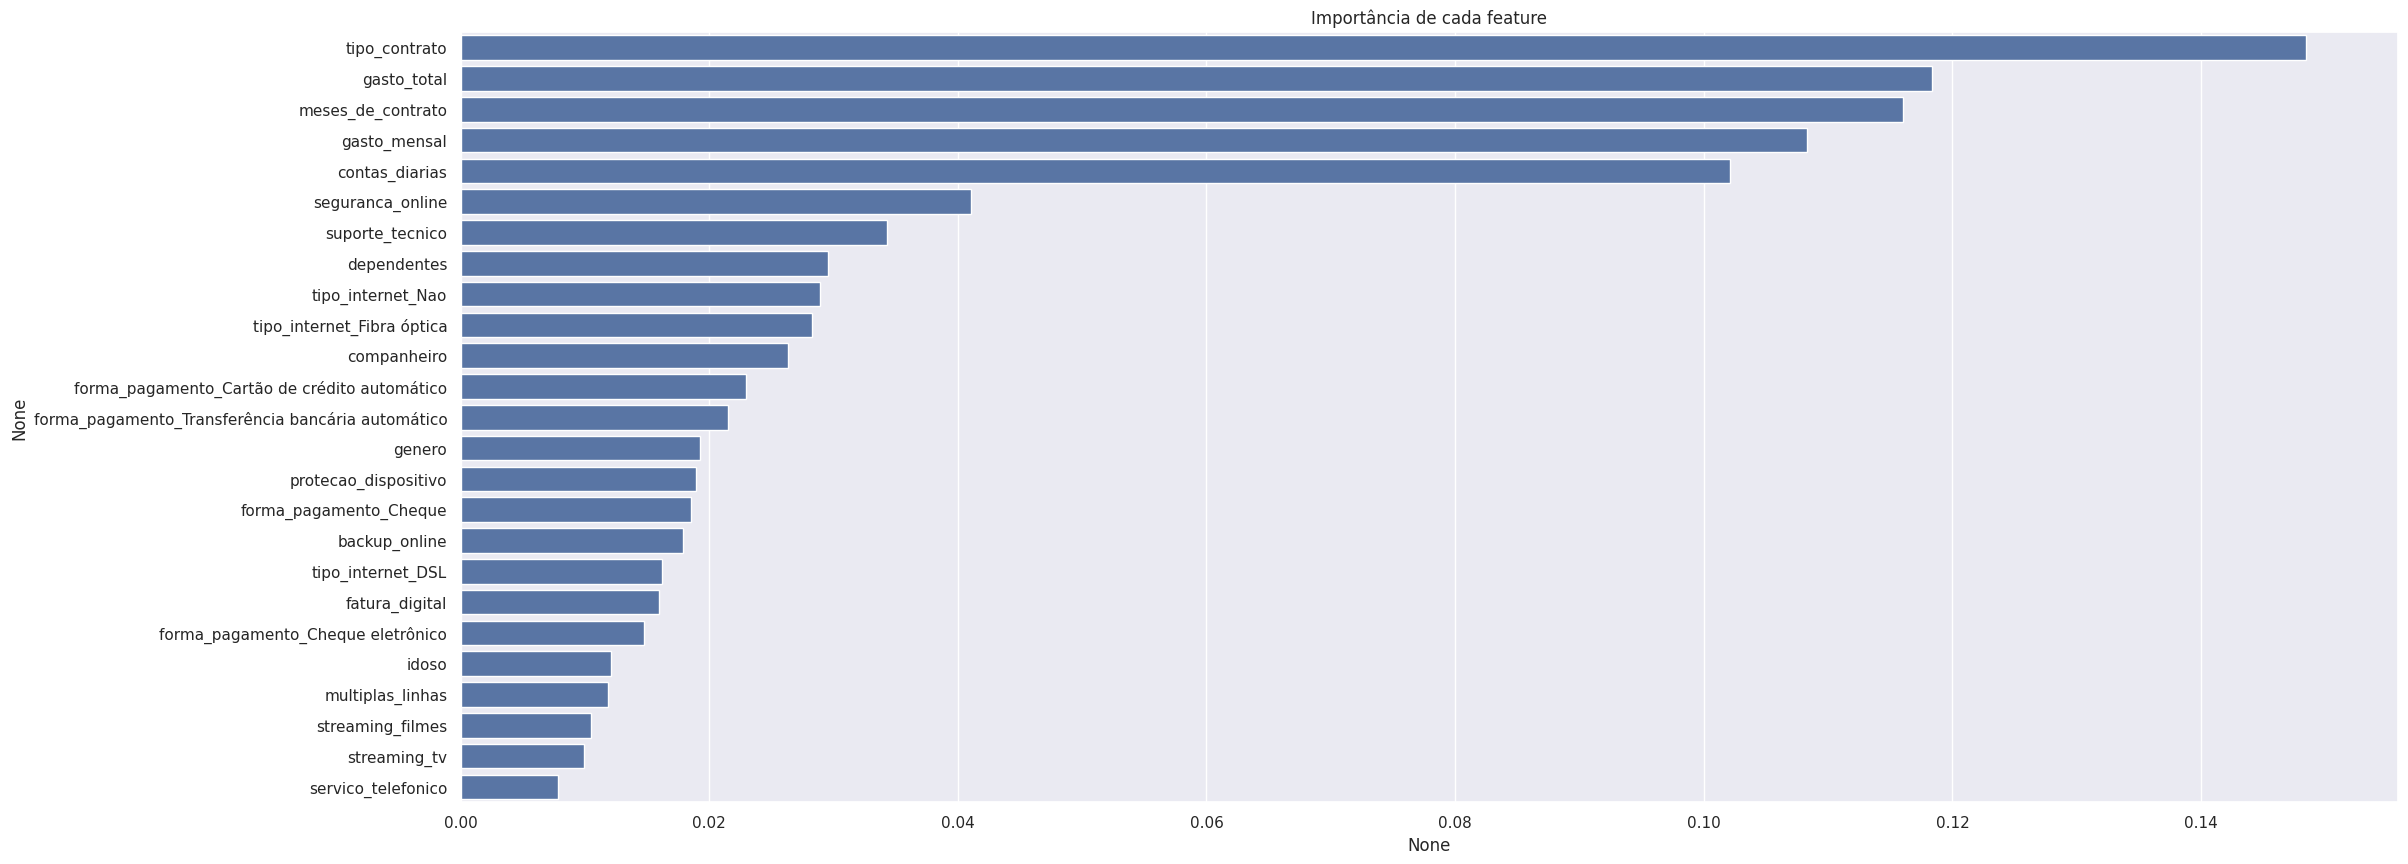

In [115]:
importances = pd.Series(data=rf.feature_importances_, index=x.columns).sort_values(ascending=False)

sns.set(rc = {'figure.figsize':(25,10)})
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')
plt.show()